In [1]:
from keras.models import load_model
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix #classification_report
import itertools  # for confusion matrix plot
from keras.utils import np_utils
%matplotlib inline

class_label = ['angry', 'happy','neutral']
n_class = len(class_label)


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
## model load
import glob
#model_path = '/github/fer/model/models/'
#model_path = '/data/webcam_strong/ak_strong.h5'
os.chdir('/data/fer_ck_cam_3_img/')
#model_path = '/data/webcam_weak/ak_strong.h5'
model_path = '/python/autokeras/fer_ck_cam_real/ak_model_fer_ck_cam.h5'
model=load_model(model_path)
#model_list = glob.glob(model_path+'/*.h5')
#model_path = os.path.join(model_path+model_list[1])
#model = load_model(model_list[2])


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
## data load
import autokeras as ak
#os.chdir('/python/autokeras/')

x_data = np.load('./x_data_fer_ck_cam.npy')
y_data = np.load('./y_data_fer_ck_cam.npy')

x_data = x_data.reshape(-1, 48,48,1)
    
    # 2. arrange the data. shape change, use specific class only, ...


class_dist = [len(y_data[y_data==i]) for i, c in enumerate(class_label)] 
print(class_dist)

y_data = np_utils.to_categorical(y_data, n_class)

[10159, 10108, 10122]


In [15]:

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, random_state=33)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state=33)

In [16]:
print(len(x_train))
print(len(x_test))
print(len(x_val))


19448
6078
4863


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("normalized")
    else:
        print('without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion_matrix')

def make_confusion_matrix(model, x, y, normalize = True):
    predicted = model.predict(x)

    pred_list = []; actual_list = []
    for i in predicted:
        pred_list.append(np.argmax(i))
    for i in y:
        actual_list.append(np.argmax(i))

    confusion_result = confusion_matrix(actual_list, pred_list)
    plot_confusion_matrix(confusion_result, classes = class_label, normalize = normalize, title = 'Confusion_matrix')
    return confusion_result

def plot_hist(hist):
    plt.figure(0)
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower left')

    plt.show()
    plt.savefig('loss_accuracy_plot')
    plt.close()

In [18]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

epoch = 30

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7),
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 20, 
                               verbose = 1, mode = 'max')


hist = model.fit(x_train, y_train, #validation_split=0.2,
                      validation_data = (x_val, y_val), 
                      shuffle = True, 
                      batch_size = 32, epochs = epoch, verbose = 1, 
                      callbacks = [early_stopping] )
scores = model.evaluate(x_test, y_test, batch_size = 32)    


Train on 19448 samples, validate on 4863 samples
Epoch 1/30
 5408/19448 [=======>......................] - ETA: 40:34 - loss: 1.1783 - acc: 0.3896

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

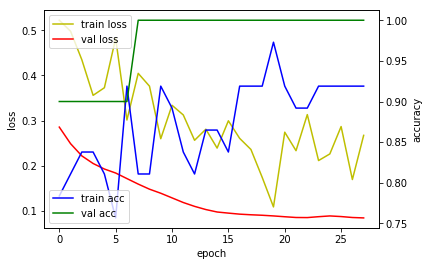

normalized
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


array([[4, 0, 0],
       [0, 3, 0],
       [0, 0, 3]], dtype=int64)

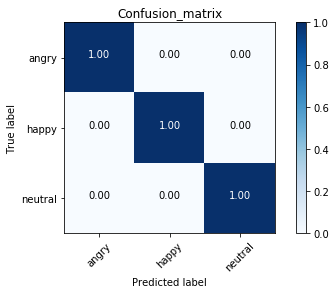

In [309]:
plot_hist(hist)
make_confusion_matrix(model,x_test,y_test)

In [11]:
## Fit generator with augmentation
from keras.preprocessing.image import ImageDataGenerator
epochs = 100
batch_size = 32
data_path = '/data/webcam/'
target_size = 48

import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))      

def preprocess_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  #load img as grayscale
    img = clahe.apply(img)  # histogram equalization
    img = np.array(img)/255.  # normalize
    return img
      
train_datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            #rescale=1./255,
            # set function that will be applied on each input
            preprocessing_function=preprocess_img,
            # image data format, either "channels_first" or "channels_last"
            data_format=None, 
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0)
    
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_img)#rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        data_path+'train', shuffle=True,
        target_size=(target_size, target_size),
        batch_size=32, color_mode = 'grayscale',
        class_mode='categorical')  #save_to_dir option is for monitoring data augmentation

validation_generator = test_datagen.flow_from_directory(
        data_path+'validation',
        target_size=(target_size, target_size),
        batch_size=32, shuffle=True, color_mode = 'grayscale',
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        data_path+'test',
        target_size=(target_size, target_size),
        batch_size=32, shuffle=False, color_mode = 'grayscale',
        class_mode='categorical')


Found 855 images belonging to 3 classes.
Found 301 images belonging to 3 classes.
Found 228 images belonging to 3 classes.


In [12]:
hist = model.fit_generator(
        train_generator,
        #steps_per_epoch=30,
        epochs=epochs,
        validation_data=validation_generator,
        #validation_steps=10,
        callbacks = [early_stopping])
    

Epoch 1/100


StopIteration: bad argument type for built-in operation

In [305]:
# 조교님 테스트

#os.chdir('/github/fer/data/')
model_path = '/github/fer/model/models/ak31_32.h5'
#model_path = '/python/autokeras/ak31_32.h5'
model=load_model(model_path)


In [306]:
# transfer learning

for layer in model.layers[0:-10]:
    layer.trainable = False

In [ ]:

data_path = '/github/fer/data/ta/'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        data_path,
        target_size=(target_size, target_size),
        batch_size=32, shuffle=False, color_mode = 'grayscale',
        class_mode='categorical')

normalized
[[0.         0.24137931 0.75862069]
 [0.         0.27777778 0.72222222]
 [       nan        nan        nan]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


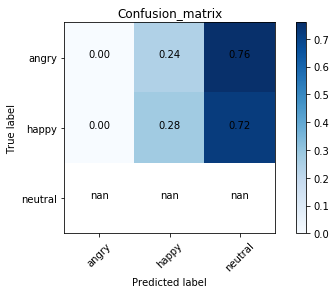

In [269]:
class_label = ['angry', 'happy','neutral']
pred = model.predict_generator(test_generator)
#from sklearn.metrics import confusion_matrix
y_true = test_generator.classes
y_pred = np.argmax(pred,axis=1)

confusion_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_result, classes = class_label, normalize = True, title = 'Confusion_matrix')

In [207]:
model.save('ak_weak_whole.h5')
os.getcwd()

'F:\\data\\webcam_weak'

In [276]:
os.getcwd()
data_path

'/github/fer/data/ta/'

In [279]:
## Fit generator with augmentation
from keras.preprocessing.image import ImageDataGenerator
epochs = 100
batch_size = 32
target_size = 48
     
train_datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=1./255, 
            # set function that will be applied on each input
            preprocessing_function=preprocess_img,
            # image data format, either "channels_first" or "channels_last"
            data_format=None) 
            # fraction of images reserved for validation (strictly between 0 and 1)
            #validation_split=0.)
    
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        data_path+'train', shuffle=True,
        target_size=(target_size, target_size),
        batch_size=batch_size, color_mode = 'grayscale', save_to_dir = data_path+'aug', save_prefix='aug_',
        class_mode='categorical')  #save_to_dir option is for monitoring data augmentation

validation_generator = test_datagen.flow_from_directory(
        data_path+'validation',
        target_size=(target_size, target_size),
        batch_size=batch_size, shuffle=True, color_mode = 'grayscale',
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        data_path+'validation',
        target_size=(target_size, target_size),
        batch_size=batch_size, shuffle=False, color_mode = 'grayscale',
        class_mode='categorical')


Found 29 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


In [281]:
early_stopping = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 20, 
                               verbose = 1, mode = 'max')

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7),
              metrics = ['accuracy'])

hist = model.fit_generator(
        train_generator,
        #steps_per_epoch=30,
        epochs=epochs,
        validation_data=validation_generator,
        #validation_steps=10,
        callbacks = [early_stopping])

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.6216 - acc: 0.4828 - val_loss: 0.9579 - val_acc: 0.5556
Epoch 2/100
1/1 [==============================] - 1s 861ms/step - loss: 1.4148 - acc: 0.5172 - val_loss: 0.8336 - val_acc: 0.6667
Epoch 3/100
1/1 [==============================] - 1s 882ms/step - loss: 1.7085 - acc: 0.4483 - val_loss: 0.7498 - val_acc: 0.7222
Epoch 4/100
1/1 [==============================] - 1s 948ms/step - loss: 1.3971 - acc: 0.5517 - val_loss: 0.6977 - val_acc: 0.7778
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.4584 - acc: 0.6552 - val_loss: 0.6711 - val_acc: 0.7778
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.9117 - acc: 0.6207 - val_loss: 0.6716 - val_acc: 0.7778
Epoch 7/100
1/1 [==============================] - 1s 894ms/step - loss: 0.7477 - acc: 0.6552 - val_loss: 0.6997 - val_acc: 0.7778
Epoch 8/100
1/1 [==============================] - 1s 911ms/step - loss: 1.1389 - acc: 0.586

In [259]:
#TA initial
model.evaluate_generator(test_generator)

[0.2754073441028595, 0.8333333134651184]

In [208]:
result.shape

(277, 3)

In [209]:
result.astype

<function ndarray.astype>

In [210]:
type(result)

numpy.ndarray

In [211]:
1e-5

1e-05

In [212]:
100+ 1e-5

100.00001